# Maternal Age Effect and Severe Germline bottleneck in the Inheritance of mitochondrial DNA heteroplasmy

This notebook replicates the analyses shown in Rebolledo-Jaramillo, Su et al (2014) *Maternal Age Effect and Severe Germline bottleneck in the Inheritance of mitochondrial DNA heteroplasmy*  [**PNAS October 28, 2014 vol. 111 no. 43 15474-15479**](http://www.pnas.org/content/111/43/15474.abstract)

This analysis uses the following datasets as inputs:

 * Allele counts produced with Galaxy pipeline (TODO: Provide link to Galaxy history here);
 * GenBank file containing sequence and annotation for human mitochondrial genome (accession `NC_012920.1`);
 * Tab-delimited file of ages for individuals analyzed here
 * Known list of problematic sites to be excluded from the analysis
 

## Import necessary python modules


 * [pandas](http://pandas.pydata.org/) - A library providing high-performance, easy-to-use data structures and data analysis tools 
 * [numpy](http://www.numpy.org/) - A package for scientific computing with Python
 * [itertools](https://docs.python.org/2/library/itertools.html) - Functions for creation of iterators for efficient looping
 * [biopython](http://biopython.org/wiki/Main_Page) - A set of Python modules for biological computation

In [1]:
import pandas as pd
import numpy as np
import itertools
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import Entrez
from Bio.Alphabet import IUPAC

## Load R extensions and install necessary R modules

In [2]:
# Load R magic, which will allow running R directly in the notebook
%load_ext rpy2.ipython

In [3]:
# Make a directory where R modules will be installed
!mkdir R

In [4]:
%%R
install.packages("shape", lib="R", repos="http://cran.cnr.berkeley.edu")

/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'http://cran.cnr.berkeley.edu/src/contrib/shape_1.4.2.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Content type 'application/x-gzip'
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  length 683515 bytes (667 KB)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: =
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robject


The downloaded source packages are in
	‘/private/tmp/RtmptJZsGA/downloaded_packages’


In [5]:
%%R
install.packages("sm", lib="R", repos="http://cran.cnr.berkeley.edu")

/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'http://cran.cnr.berkeley.edu/src/contrib/sm_2.2-5.4.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  length 256311 bytes (250 KB)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 250 KB


  res = super(Function, self).__call__(*new_args, **new_kwargs)



The downloaded source packages are in
	‘/private/tmp/RtmptJZsGA/downloaded_packages’


In [6]:
%%R
install.packages("vioplot", lib="R", repos="http://cran.cnr.berkeley.edu")

/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'http://cran.cnr.berkeley.edu/src/contrib/vioplot_0.2.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  length 3801 bytes

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 3801 bytes


  res = super(Function, self).__call__(*new_args, **new_kwargs)



The downloaded source packages are in
	‘/private/tmp/RtmptJZsGA/downloaded_packages’


In [7]:
%%R
require(shape, lib.loc="R")
require(sm, lib.loc="R")
require(vioplot, lib.loc="R")

/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: shape

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: sm

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Package 'sm', version 2.2-5.4: type help(sm) for summary information

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/anton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: vioplot

  res = super(Function, self).__call__(*new_args, **new_kwargs)


## Load datasets

In this example all necessary data are located in Galaxy's history. They can be accessed using the `get()` function. For example, to load data in the first history item into Jupyter environment simply use `get(1)`, where `1` is the history item number. 

Obviously, if your history looks different, change the numbers in the cells below. 

In [8]:
# Load Allele Counts

# Uncomment for Galaxy use
#with open(get(1)) as ac:
with open("/Users/anton/sandbox/pnas-2014/Alelle_Counts.tab") as ac: #<- remove for Galaxy use
    first_line = ac.readline()
    if first_line.startswith("#"):
        df = pd.read_table(ac)
    else:
        df = pd.read_table(ac,header=None)

# The line below prints the first twio lines of the data to give you an idea
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,M493-ch,chrM,1,0,0,3297,0,0,0,2011,0,5308,1,G,.,0
1,M480-ch,chrM,1,0,0,2996,0,0,0,2080,0,5076,1,G,.,0


In [9]:
# Load Genbank file containing mitochondrial genome sequence and annotations
# See http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc55
# This loads record with Accession:NC_012920.1  GI:251831106
# This cell should return "NC_012920.1 with 105 features"

# Code below loads directly from NCBI but requires Internet connection
# Alternatively you can load this dataset from history using the line below:
# rCRS = SeqIO.read(get(<HISTORY ITEM NUMBER>), "genbank")

Entrez.email = "A.N.Other@example.com"
handle = Entrez.efetch(db="nucleotide", rettype="gb", retmode="text", id="251831106")
rCRS = SeqIO.read(handle, "genbank")
handle.close()
print("%s with %i features" % (rCRS.id, len(rCRS.features)))

NC_012920.1 with 105 features


In [10]:
# Load individuals' ages (ages in days)

# Uncomment for Galaxy use
#with open(get(5)) as sa:
with open("/Users/anton/sandbox/pnas-2014/Sample_ages.tab") as sa:
    first_line = sa.readline()
    if first_line.startswith("#"):
        sampAges = pd.read_table(sa)
    else:
        sampAges = pd.read_table(sa,header=None)
sampAges.head(2)

,0,1,2,3
0,M132,16658,M132C1,7460
1,M137,14294,M137C2,6202


## Define problematic sites and regions

 * Problematic sites are defined as heteroplasmic sites that failed to be validated by experimental means.
 * Problematic reagions include:
   - mtDNA homopolymeres
   - region around the artificial "N" at position 3107
   - regions within 50 bp of the long range PCR primers

In [11]:
# Read in bad (problematic) sites dataset from history

# knownBadhqSites = pd.read_table(get(2),header=None)

knownBadhqSites = pd.read_table("/Users/anton/sandbox/pnas-2014/Known_bad_sites.tab",header=None)

In [12]:
# Define problematic regions

mask = [(66,71),(303,311),(514,523),(12418,12425),(16184,16193),
      (3105,3109),(2817,2868),(3320,3370),(10796,10846),(11520,11570)]

maskRegions = list()
for start,end in mask:
    maskRegions+=range(start,end+1)

## Prepare data
If a header was present in the allele counts input dataset, Pandas assigned the column names automatically. However we will standardize the column names so they can be easily accessed later.

In [13]:
df.columns=["sample","reference","position","A","C","G","T","a","c","g","t","cvrg","nalleles","major","minor","maf"]

In [14]:
# Let's take a look at the first two lines in the data frame
df.head(2)

,sample,reference,position,A,C,G,T,a,c,g,t,cvrg,nalleles,major,minor,maf
0,M493-ch,chrM,1,0,0,3297,0,0,0,2011,0,5308,1,G,.,0
1,M480-ch,chrM,1,0,0,2996,0,0,0,2080,0,5076,1,G,.,0


In our data, all but one mother-child pair conforms to the naming convention:

mother|child
------|-----
family-tissue|familyChild#-tissue
M477-ch|M477C1-ch

However, the pair M502G (grandmother) and M501 (mother) break the rule. So, we adjusted their ids accordingly:



In [15]:
old = ["M502G-ch","M502G-bl","M501-ch","M501-bl"]
new = ["M502-ch","M502-bl","M502C1-ch","M502C1-bl"]
df.replace(to_replace=old,value=new,inplace=True)

## Plot sequencing depth distribution (Fig. S7)

At this point we can calculate the coverage distribution of each sample, as shown in Figure S7 in the PNAS paper. To do so, we need to split the dataframe into blood and cheek dataframes, and make the object available to R (via [Rpy2](http://rpy.sourceforge.net/)).

In [16]:
# Here we split the dataframe into blood and cheek samples
blood = df[df['sample'].str.contains("-bl")]
cheek = df[df['sample'].str.contains("-ch")]

In [17]:
# Let's look at blood data frame
blood.head(2)

,sample,reference,position,A,C,G,T,a,c,g,t,cvrg,nalleles,major,minor,maf
1176398,M478C2-bl,chrM,1,0,0,1425,0,0,0,1163,0,2588,1,G,.,0
1176399,M240C1-bl,chrM,1,0,0,1559,0,0,0,1379,0,2938,1,G,.,0


In [18]:
# And at the cheek data frame
cheek.head(2)

,sample,reference,position,A,C,G,T,a,c,g,t,cvrg,nalleles,major,minor,maf
0,M493-ch,chrM,1,0,0,3297,0,0,0,2011,0,5308,1,G,.,0
1,M480-ch,chrM,1,0,0,2996,0,0,0,2080,0,5076,1,G,.,0


In [19]:
# Use Rmagic to load data into R using the -i flag
# This step will take a bit (~2 min)

%R -i cheek,blood

Let's peek at the R version of the blood dataframe:

In [20]:
%%R
head(blood,2)

           sample reference position A C    G T a c    g t cvrg nalleles major
1176398 M478C2-bl      chrM        1 0 0 1425 0 0 0 1163 0 2588        1     G
1176399 M240C1-bl      chrM        1 0 0 1559 0 0 0 1379 0 2938        1     G
        minor maf
1176398     .   0
1176399     .   0


Transform numeric looking columns into actual numeric columns to guarantee the value types:

In [21]:
%%R
tonumeric = c(3:13,16)
blood[,tonumeric] = apply(blood[,tonumeric], 2, function(x) as.numeric(as.character(x)))
cheek[,tonumeric] = apply(cheek[,tonumeric], 2, function(x) as.numeric(as.character(x)))

Define custom R function to generate **Figure S7**:

In [22]:
%%R
boxPlotCvrg = function(data,tissue){
    
    names = sort(unique(data[["sample"]]))
    data[["sample"]] = factor(data[["sample"]],levels=names)
    
    boxplot(log10(cvrg)~sample,data=data,whisklty="solid",outline=F,
            whisklwd=0.5,boxlwd=1,medlwd=1,medcol="red",main="",
            ylab="log10(coverage)",bty="n",frame=F,boxcol="white",
            boxfill="black",medlwd=3,whiskcol="grey",staplecol="grey",ylim=c(2,6))
    
    mtext(tissue,adj=0,side=3,las=1,at=length(names)/2,font=2,cex=1.25)
    }

### Plot the figure
You can adjust the size of the plotting image by adjusting:

* `-w` = width
* `-h` = height
* `-u-` = units
* `-r` = resolution

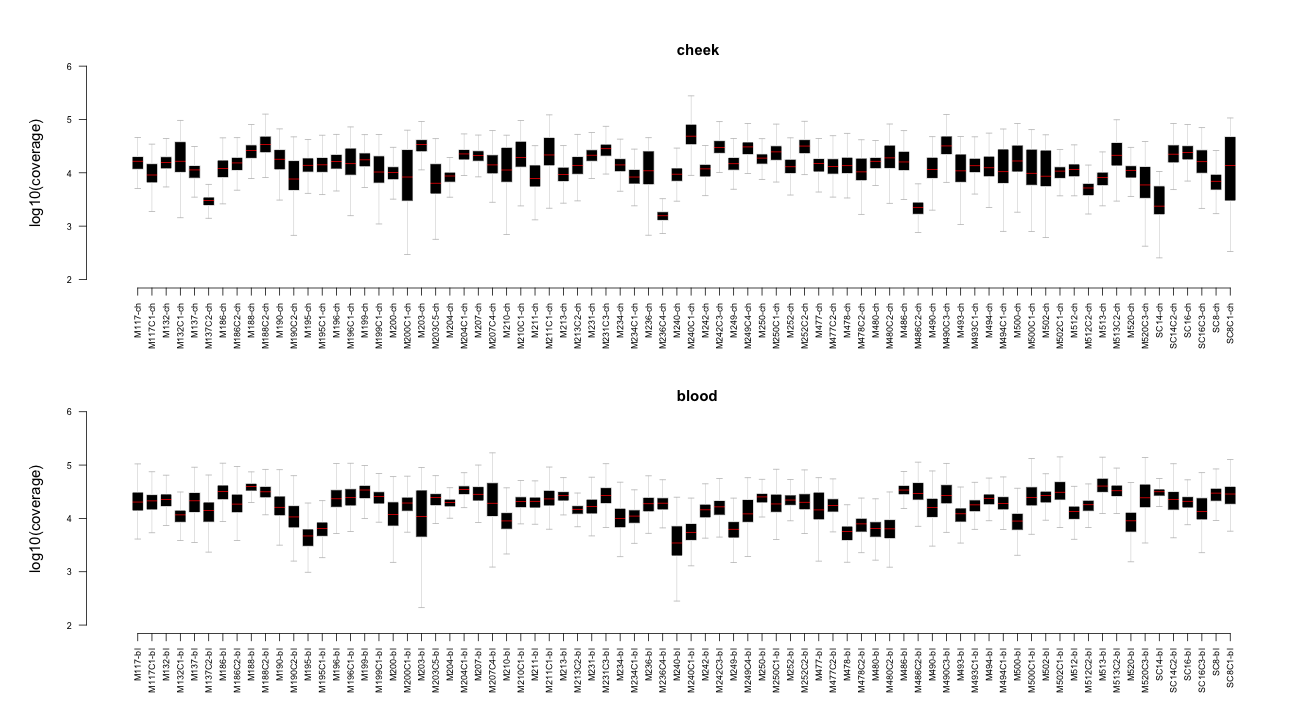

In [23]:
%%R -w 18 -h 10 -u in -r 72

par(las=2)
par(mar=c(4,4,4,1))
par(oma=c(2,2,0,0))
par(mfrow=c(2,1))
par(cex.lab=1.25)
par(cex.axis=0.75)

boxPlotCvrg(cheek,"cheek")
boxPlotCvrg(blood,"blood")

## Define high quality heteroplasmic sites

We define high quality (HQ) sites as:
 
  1. minor allele frequency (maf) ≥ 1%
  2. coverage ≥ 1000
  3. maf balance (1% in forward and reverse strands)
  4. no strand bias
  5. outside "problematic sites":
     - mtDNA homopolymeres
     - around the artificial "N" at position 3107
     - within 50 bp of the long range PCR primers


In [24]:
# Filter sites on minor allele frequncy (maf), coverage (cvrg) and wheather 
# the sites are located in problematic regions
# The list of problematic region (maskRegions) is defined in cell 12 above
hq_sites = df[(df.maf>=0.01) & (df.cvrg>=1000) & ~df.position.isin(maskRegions)]

In [25]:
len(hq_sites)

572

By applying these initial filters, we reduced the dataframe from ~2 million lines to **572** lines only, which is much more manageable. Next, we calculate strand bias and maf balance for these 572 sites. The strand bias calciulation is perfomed according to Guo Y et al. [2012](http://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-666)


In [26]:
# Compute strand and minor allele frequency bias

def strand_stats(x, mafThreshold=0.01):
    falleles = ['A','C','G','T']
    ralleles = ['a','c','g','t']
    sample,position,major,minor,coverage,maf = x[['sample','position','major','minor','coverage','maf']]
    fcounts = x[falleles]
    rcounts = x[ralleles]
    if minor!='.':
        index_major = falleles.index(major)
        index_minor = falleles.index(minor)

        fcount_minor = float(fcounts[index_minor])
        ftotal = fcount_minor + fcounts[index_major]
        
        rcount_minor = float(rcounts[index_minor])
        rtotal = rcount_minor + rcounts[index_major]
        
        minor_total = float(fcount_minor + rcount_minor)
        site_total = ftotal + rtotal

        try:
            strandBias = abs( (fcount_minor/ftotal) - (rcount_minor/rtotal) ) / (minor_total/site_total)
        except:
            strandBias = np.nan
            
        try:
            maf_frwd = fcount_minor/sum(fcounts)
        except:
            maf_frwd = np.nan
        try:
            maf_rvrs = rcount_minor/sum(rcounts)
        except:
            maf_rvrs = np.nan
            
        if (maf_frwd>=mafThreshold) and (maf_rvrs>=mafThreshold):
            mafBalance = 1
        else:
            mafBalance = 0
    else:
        strandBias = float(2)
        mafBalance = 0

    return pd.Series([strandBias,mafBalance])

In [27]:
# Apply strand calculations to the data

biasCols = hq_sites.apply(strand_stats,axis=1,args=(0.01,))
biasCols.columns = ["strandBias","mafBalance"]
hq_sites = pd.concat([hq_sites,biasCols],axis=1)

In [28]:
# Filter on strand and maf balance

hq_sites = hq_sites[(hq_sites.strandBias<=1) & (hq_sites.mafBalance==1) ]
len(hq_sites)

184

> <i class=icon-exclamation> There is an additional screenning step not shown here, where we calculate the cycle bias of the site, i.e. whether the alternative allele is supported primarily by nucleotides within 25 bp of the read ends. It requires a list of sites and the bam files originally quantified by the Naive Variant Caller tool. The script is shown below </i> 

> There are 9 such cases, and two additional cases of sites we could not replicate with a new long range PCR (deemed PCR errors). These 11 sites are provided as an additional file in the history "Known_bad_sites.tab"

#import pysam

'''
def cycle_bias(sample,pos,minor,bam,win=25):
    tot_minor_reads = 0
    minor_in_edge = 0
    samfile = pysam.AlignmentFile(bam,"rb")
    
    for pileupcolumn in samfile.pileup('chrM', pos-1, pos, stepper='all',max_depth=10000000, mask=False,truncate=True):
        if pileupcolumn.pos==pos-1:
            for pileupread in pileupcolumn.pileups:
                position_in_segment = pileupread.query_position
                aligned_segment = pileupread.alignment
                
                if dict(aligned_segment.tags)["RG"]==sample:
                    segment_minor = aligned_segment.query_sequence[position_in_segment]
                    segment_qual = aligned_segment.query_qualities[position_in_segment]
                    if segment_minor == minor and segment_qual >=30:
   
                        tot_minor_reads+=1

                        rlen = aligned_segment.query_length
                        
                        edges = range(0,win)+range(rlen-win,rlen+1)
            
                        if position_in_segment in edges:
                            minor_in_edge+=1
    try:
        ratio = minor_in_edge/float(tot_minor_reads)
        
    except:
        ratio = np.nan
    
    
    return ratio
'''

'''
WORKS WITH ANOTHER DATASET. NOT TESTED FOR THE MTDNA PROJECT
# bam files need to be named accordingly: M478C2-bl.bam

bamdirbase = "/path/to/nvc/ready/bam/files/directory"


cbias = []

for sample,position,minor in hq_sites[["sample","position","minor"]].itertuples(index=False):
    sampleName = sample.split(".")[0]
    bam = "%s/srt.%s.nvcReady.bam" % (bamdirbase,sampleName)
    
    cbias.append(cycle_bias(sampleName,int(position),minor,bam))

hq_sites["cycle_bias"] = cbias
hq_sites = hq_sites[hq_sites.cycle_bias<=0.85]
len(hq_sites)
'''

In [29]:
# Set bad sites column names 
knownBadhqSites.columns=["sample","position"]

# Adjust naming convention for the anomalous grandmother-mother pair
knownBadhqSites.replace(to_replace=old,value=new,inplace=True)

# Transform bad sites into a hashable object 
bad = set(knownBadhqSites.itertuples(index=False))

# Get a boolean array to filter high quality sites
good = [x not in bad for x in hq_sites[['sample','position']].itertuples(index=False)]

# Finally, filter high quality sites
hq_sites = hq_sites[good]

In [30]:
len(hq_sites)
#hq_sites.to_csv("hq173.txt",sep="\t",index=False)

173

## Test statistical significance of high quality sites
Finally, we calculate the significance of the minor allele frequency of a site provided the error rate at that position. The error rate is estimated from the remaining 155 samples, and the expected allele acounts are compared to the observed allele counts:

In [31]:
from scipy.stats import poisson

In [32]:
# We define a poisson function that will take a single high quality site, and explore the variability of
# the position among the remaining samples


def poisson_pval(current_df,sample):
    alleles = ['A','C','G','T','a','c','g','t']
    
    sample_counts = list(current_df.loc[current_df['sample']==sample, alleles].iloc[0,:])
    others_counts = list(current_df.loc[current_df['sample']!=sample, alleles].apply(sum,axis=0))
    sample_coverage = sum(sample_counts)
    
    observed_error = (sum(others_counts) - max(others_counts))/float(sum(others_counts))
    sample_nonMajor_counts = int(sample_coverage - max(sample_counts))
    
    pvalue = poisson.pmf(sample_nonMajor_counts, observed_error*sample_coverage)
    
    return pvalue

In [33]:
poisson_pvalues = []

for sample,position in hq_sites[["sample","position"]].itertuples(index=False):
    poisson_pvalues.append(poisson_pval(df[df['position']==position],sample))

    
hq_sites["poisson"] = poisson_pvalues
hq_sites = hq_sites[hq_sites.poisson<=0.05]
len(hq_sites)

173

As described in the paper, all sites were statiscally significant under the Poisson and Likelihood (not shown here) frameworks.

# Screening for contamination
In our previous publication, Dickins, Rebolledo-Jaramillo, et al (2014) Controlling for contamination in resequencing studies with a reproducible web-based phylogentic approach [BioTechniques, 56(3):134–141](http://goo.gl/jv2J34), we described warning signs of a potential contamination. They include:
 1. Excess heteroplasmic sites (≥5 per sample)
 2. Tight minor allele frequency distribution
 3. Non-family related positions of heteroplasmic sites
 
We routinely apply our contamination detection pipeline, so we are confident our sites in the PNAS paper were not artifacts. As an example of the screening for contamination, we can plot the number of sites and the minor allele frequency distribution of all samples in the high quality sites set:

In [34]:
# Make R aware of the hq_sites dataframe
%R -i hq_sites

In [35]:
%%R

# Adjust value types in the hq_sites dataframe

tonumeric = c(3:13,16:18)
hq_sites[,tonumeric] = apply(hq_sites[,tonumeric], 2, function(x) as.numeric(as.character(x)))
head(hq_sites,2)

      sample reference position    A C  G T    a c  g t cvrg nalleles major
2030 M490-ch      chrM      185 2663 0 73 0 3116 0 92 0 5944        2     A
2074 M490-ch      chrM      189 2519 2 29 0 3159 0 41 0 5750        0     A
     minor     maf strandBias mafBalance      poisson
2030     G 0.02776 0.07194105          1 1.010608e-05
2074     G 0.01217 0.11750754          1 1.546148e-05


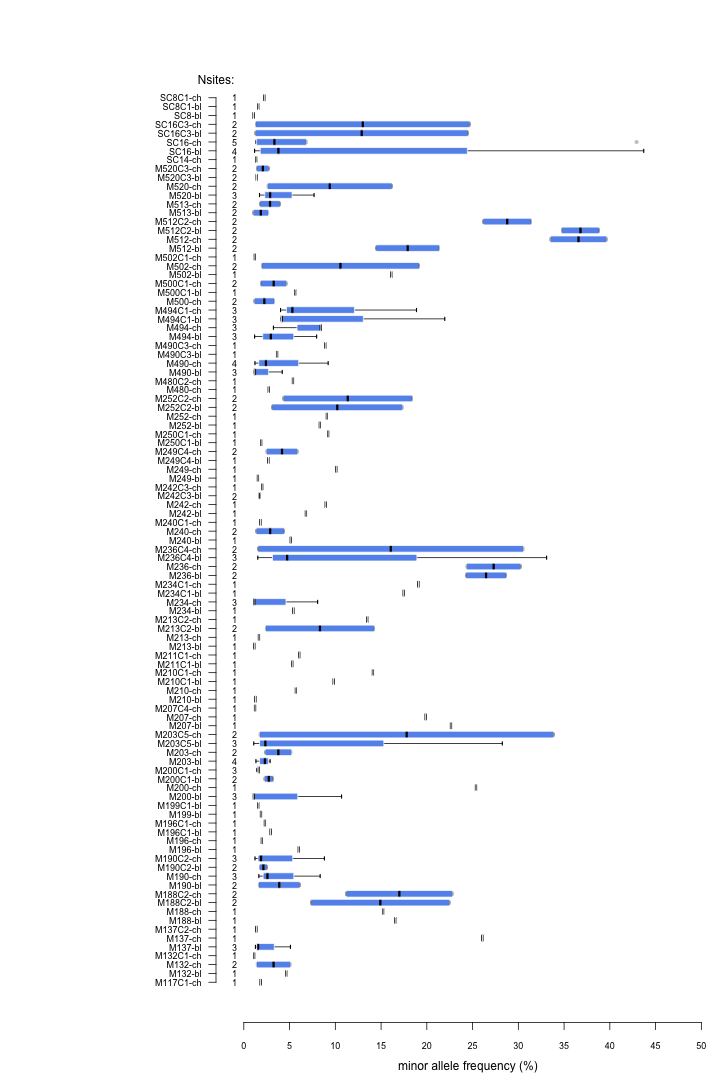

In [36]:
%%R -w 10 -h 15 -u in -r 72

# Plot hq_sites number of sites and minor allele frequency distribution

par(mar=c(4,15,4,0))
boxplot(
  maf~sample,
  data=hq_sites,
  pch=16,cex=0.75,
  outcol="azure3",outline=T,
  whisklty=1,whiskwd=1.5,
  staplelwd=1.5,
  boxwex=0.75,boxcol="white",boxfill="cornflowerblue",
  horizontal=T,cex.axis=0.75,las=2,
  frame=F,xaxt="n",ylim=c(-0.01,0.5)
  )

axis(1,at=seq(0,5,0.5)/10,lab=100*(seq(0,5,0.5)/10),cex.axis=0.75)
title(xlab="minor allele frequency (%)",line=2.5,cex.axis=0.75)

nsites = table(hq_sites[["sample"]])
for (i in 1:length(nsites)){
  text(-0.01,i,lab=nsites[i],cex=0.75)
}
mtext("Nsites:",side=3,line=-2,at=0,adj=1.25)

## Placing high quality sites into *quartets*

For each high quality site, we can retrieve the minor allele frequency information for the remaining 3 samples in the family collection. So, a quartet is simply a tabulation of the minor allele frequency for the mother blood and cheek, and her child blood and cheek, for the same site. Below is an example of a quarted for family **M494**:

family|position|major|minor|mother_cheek|mother_blood|child_cheek|child_blood
------|--------|-----|-----|------------|------------|-----------|-----------
M494|9196|G|A|0.032|0.030|0.000|0.000




However, before we can do that, we need to add family information to the high quality sites. We will do that by extracting the family id from each sample's id. It is also useful to have a way to split the data by tissue or member of the pair, so we will add the columns `family`, `tissue` and `member`, accordingly.

In [37]:
# Get family id from sample id
# i.e. M512C1-ch returns M512

def getfamlabels(samplename):    
    nameparts = ["".join(x) for _, x in itertools.groupby(samplename, key=str.isdigit)]
    family = "".join(nameparts[:2])
    if "-ch" in nameparts:
        tissue = "cheek"
    else:
        tissue = "blood"
    
    if len(nameparts)>3:
        pairclass = "child"
    else:
        pairclass = "mother"
        
    return pd.Series([family,tissue,pairclass])

In [38]:
# Apply the above function to the data

hq_sites[["family","tissue","member"]] = hq_sites["sample"].apply(getfamlabels)

In [39]:
hq_sites.head(2)

,sample,reference,position,A,C,G,T,a,c,g,...,nalleles,major,minor,maf,strandBias,mafBalance,poisson,family,tissue,member
2030,M490-ch,chrM,185,2663,0,73,0,3116,0,92,...,2,A,G,0.02776,0.071941,1,0.000010,M490,cheek,mother
2074,M490-ch,chrM,189,2519,2,29,0,3159,0,41,...,0,A,G,0.01217,0.117508,1,0.000015,M490,cheek,mother


In [40]:
# Now we can extract the unique quartets by selecting the "family" and "position" columns

unique_quartets = hq_sites[["family","position"]].drop_duplicates()
len(unique_quartets)

98

In [41]:
unique_quartets.head(2)

,family,position
2030,M490,185
2074,M490,189


In [42]:
# For each family_id/position combination, 
# retrieve the information for all 4 members of the quartets
# from the original data dataframe

def getQuartets(hqsite):
    position = hqsite['position']
    familyid = hqsite['family']
    allmembers = [s for s in df['sample'].drop_duplicates() if s.startswith(familyid)]
    mother = min([len(x) for x in allmembers])
    child = max([len(x) for x in allmembers])
    if len(allmembers)==4:

        for member in allmembers:
            if len(member)==mother and member.endswith("-ch"):
                motherCheek = df[(df['sample']==member) & (df['position']==position)][['major','minor','maf']].squeeze()

            elif len(member)==mother and member.endswith("-bl"):
                motherBlood = df[(df['sample']==member) & (df['position']==position)][['major','minor','maf']].squeeze()

            elif len(member)==child and member.endswith("-ch"):
                childCheek = df[(df['sample']==member) & (df['position']==position)][['major','minor','maf']].squeeze()

            else:
                childBlood = df[(df['sample']==member) & (df['position']==position)][['major','minor','maf']].squeeze()

        return pd.Series([familyid,position]+list(motherCheek)+list(motherBlood)+list(childCheek)+list(childBlood))
    else:
        pass

In [43]:
# Apply getQuartets to data

quartets = unique_quartets.apply(getQuartets,axis=1)

In [44]:
# Set column names
# mc: mother cheek
# mb: mother blood
# cc: child cheek
# cb: child blood

quartets.columns = ["family","position","mcMajor","mcMinor","mcMAF","mbMajor","mbMinor","mbMAF",
                    "ccMajor","ccMinor","ccMAF","cbMajor","cbMinor","cbMAF"]

In [45]:
quartets.head(2)

,family,position,mcMajor,mcMinor,mcMAF,mbMajor,mbMinor,mbMAF,ccMajor,ccMinor,ccMAF,cbMajor,cbMinor,cbMAF
2030,M490,185,A,G,0.02776,A,G,0.00658,A,G,0.00393,A,G,0.00128
2074,M490,189,A,G,0.01217,A,G,0.00370,A,G,0.00208,A,G,0.00091


We can add even more information to the quartets table. For instance, the impact of the alternative allele and the nucleotide change class:

In [46]:
# Define function for generating protein translation

def translate(sequence,gene):
    if len(str(sequence))%3!=0:
        add=3 - (len(str(sequence))%3)
    else:
        add=0

    if genedb[gene]["strand"]==1:
        modseq=str(sequence)+add*'A'        
    else:
        modseq=str(sequence.reverse_complement())+add*'A'

    try:
        translation=str(Seq(modseq,IUPAC.unambiguous_dna).translate(table=2,cds=True))
    except:
        translation=[]

    return translation

In [47]:
# Define function for estimating evolutionary impact
# The function determines if a heteroplamic site
# synonymous/non-synonomous and if the change is transitional or transversional 

def evoImpact(quartet):
    het,major,minor = quartet
    pos  = int(het)-1
    gene = [g for g in genedb if genedb[g]['end']>=pos>=genedb[g]['start']][0]

    if gene in [feature.qualifiers['gene'][0] for feature in rCRS.features if feature.type=="CDS"]:

        majorseq = rCRS.seq.tomutable()
        minorseq = rCRS.seq.tomutable()
        majorseq[pos] = major
        minorseq[pos] = minor
        ref_seq = rCRS.seq[genedb[gene]["start"]:genedb[gene]["end"]]
        major_seq = majorseq[genedb[gene]["start"]:genedb[gene]["end"]]
        minor_seq = minorseq[genedb[gene]["start"]:genedb[gene]["end"]]

        if (translate(ref_seq,gene)==translate(minor_seq,gene)):
            ptimpact = "syn"
        else:
            ptimpact = "nonsyn"
    else:
        ptimpact = "-"

    ntClass={'pu':['A','G'],'py':['C','T']}
    majorClass=[k for k,v in ntClass.iteritems() if major in v]
    minorClass=[k for k,v in ntClass.iteritems() if minor in v]
    if majorClass==minorClass:
        ntimpact='ts'
    else:
        ntimpact='tv'


    return pd.Series([ptimpact,genedb[gene]['class'],ntimpact])

In [48]:
# Using BioPython rCRS object defined in cell 10
# Parse mitochondrial genome features

genedb = dict()
labs = ["class","start","end","strand"]
for feature in rCRS.features:
    if feature.type in ["rRNA","tRNA","CDS"]:
        ftype = feature.type
        name = feature.qualifiers['gene'][0]
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = int(feature.location.strand)
        genedb[name] = dict(zip(labs,[ftype,start,end,strand]))
genedb['D-loop1'] = dict(zip(labs,["Dloop",0,576,1]))
genedb['D-loop2'] = dict(zip(labs,["Dloop",16023,16569,1]))

In [49]:
# We set the ancestral state to the alleles found in the mother's blood sample.

quartets[["ptchange","class","ntchange"]] = quartets[['position','mbMajor','mbMinor']].apply(evoImpact,axis=1)

Finalized quartets table:

In [50]:
quartets.head(2)

,family,position,mcMajor,mcMinor,mcMAF,mbMajor,mbMinor,mbMAF,ccMajor,ccMinor,ccMAF,cbMajor,cbMinor,cbMAF,ptchange,class,ntchange
2030,M490,185,A,G,0.02776,A,G,0.00658,A,G,0.00393,A,G,0.00128,-,Dloop,ts
2074,M490,189,A,G,0.01217,A,G,0.00370,A,G,0.00208,A,G,0.00091,-,Dloop,ts


## Plot the number of heteroplasmic sites per individual or family (Fig. S11)

In [51]:
# Since we modified the hq_sites dataframe, we have to reload it in R

%R -i hq_sites,quartets

In [52]:
%%R

# Adjust value types in the hq_sites dataframe
tonumeric = c(3:13,16:18)
hq_sites[,tonumeric] = apply(hq_sites[,tonumeric], 2, function(x) as.numeric(as.character(x)))
head(hq_sites,2)

      sample reference position    A C  G T    a c  g t cvrg nalleles major
2030 M490-ch      chrM      185 2663 0 73 0 3116 0 92 0 5944        2     A
2074 M490-ch      chrM      189 2519 2 29 0 3159 0 41 0 5750        0     A
     minor     maf strandBias mafBalance      poisson family tissue member
2030     G 0.02776 0.07194105          1 1.010608e-05   M490  cheek mother
2074     G 0.01217 0.11750754          1 1.546148e-05   M490  cheek mother


In [53]:
%%R

# Frequency (number of sites per individual)

getFreq = function(data,tissue,member) {
    
    siteFreq = data.frame(table(table(as.character(data[(data[["tissue"]]==tissue) & (data[["member"]]==member),1]))))
    siteFreq = unlist(apply(siteFreq,1,FUN=function(x) rep(x[1],x[2])))
    siteFreq = as.numeric(c(rep(0,39-length(siteFreq)),siteFreq))
        
    return(siteFreq)
        }

In [54]:
%%R


# Size of circles

symbolPlot = function(data,pos) {
    
    symbols(rep(pos,length(unique(data))),
            sort(unique(data)),circles=(data.frame(table(data))$Freq)*0.01,
            add=T,inches=F,bg="black")
}

In [55]:
%%R

# Backbone boxplot

boxPlotNsites = function(data,pos,addOpt="False"){                    
    boxplot(data,ylim=c(-2,maxSites),frame=F,axes=F,xlim=c(1,7),at=pos,col=rgb(0,0,0,0),
            boxlwd=2,boxcol="coral3",medcol="coral3",whisklty="solid",whiskcol="coral3",
            staplecol="coral3",add=as.logical(addOpt),outline=F)

}

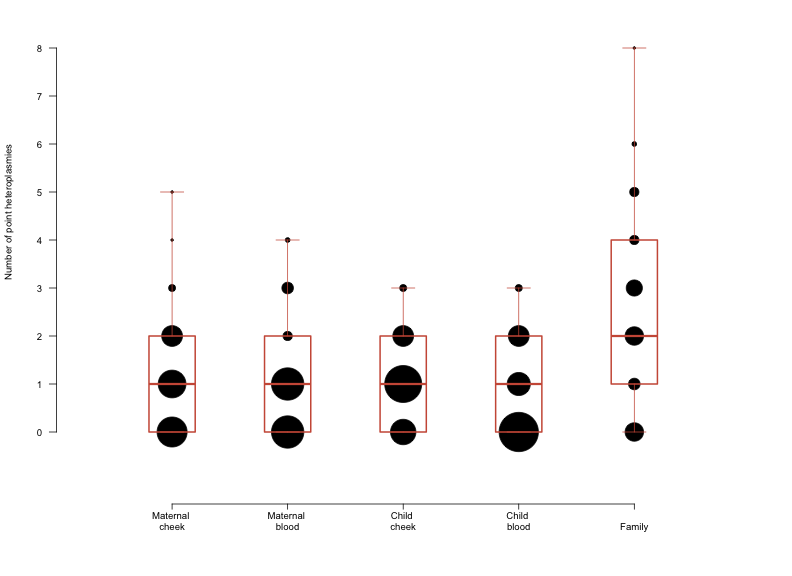

In [56]:
%%R -w 11 -h 8 -u in -r 72

mc = getFreq(hq_sites,"cheek","mother")
mb = getFreq(hq_sites,"blood","mother")
cc = getFreq(hq_sites,"cheek","child")
cb = getFreq(hq_sites,"blood","child")

fam = data.frame(table(table(quartets[["family"]])))
fam = unlist(apply(fam,1,FUN=function(x) rep(as.numeric(x[1]),x[2])))
fam = as.numeric(c(rep(0,39-length(fam)),fam))
                            
maxSites = max(c(mc,mb,cc,cb,fam))
par(mar=c(2,2,2,1))
par(oma=c(0,0,0,0))                           

plot(1:7,1:7,type="n",ylim=c(-2,maxSites),frame=F,axes=F)

symbolPlot(mc,2)
symbolPlot(mb,3)
symbolPlot(cc,4)
symbolPlot(cb,5)
symbolPlot(fam,6) 

Lab = c("Maternal \ncheek","Maternal \nblood","Child \ncheek","Child \nblood","Family")
    
axis(1,at=2:6,lab=Lab,pos=-1.5,las=1,cex.axis=0.8,tck=-0.01)
axis(2,at=0:maxSites,lab=0:maxSites,pos=1,las=2,cex.axis=0.8)
mtext("Number of point heteroplasmies",2,1,cex=0.8,adj=0.7)

      
par(new=T)
boxPlotNsites(mc,2)
boxPlotNsites(mb,3,"True")
boxPlotNsites(cc,4,"True")
boxPlotNsites(cb,5,"True")
boxPlotNsites(fam,6,"True") 

## Plot distribution of high quality heteroplasmies (Fig. S10)

In [57]:
%%R

data = quartets
uniqueFamilies = sort(unique(as.character(data$family)))
faid = cbind(1:length(uniqueFamilies),uniqueFamilies)

plotid=c()
for (s in as.character(data$family)){
    plotid=c(plotid,faid[faid[,2]==s,1])
}
data$id = as.numeric(plotid)
data$position = as.numeric(as.character(data$position))
head(data)

      family position mcMajor mcMinor   mcMAF mbMajor mbMinor   mbMAF ccMajor
2030    M490      185       A       G 0.02776       A       G 0.00658       A
2074    M490      189       A       G 0.01217       A       G 0.00370       A
2196    M520      200       G       A 0.02581       G       A 0.01716       G
13311   M480     1211       G       A 0.02724       G       A 0.01064       G
15293   M513     1391       T       C 0.03968       T       C 0.02697       T
28383   M513     2581       A       G 0.01762       A       G 0.00043       A
      ccMinor   ccMAF cbMajor cbMinor   cbMAF ptchange class ntchange id
2030        G 0.00393       A       G 0.00128        - Dloop       ts 22
2074        G 0.00208       A       G 0.00091        - Dloop       ts 22
2196        A 0.00497       G       A 0.00156        - Dloop       ts 28
13311       A 0.00021       G       . 0.00000        -  rRNA       ts 21
15293       C 0.00111       T       C 0.00047        -  rRNA       ts 27
28383       G 0.

In [58]:
%%R

# Define colors for each mitochondrial genome features

alp  =200
trna ="blue"
rrna ="lightseagreen"
prot ="orange"
dloop="red"

colors=c()
for (c in data[["class"]]) if (c=="Dloop") {
    colors=c(colors,dloop)
    } else if (c=="tRNA") {
        colors=c(colors,trna)
    } else if (c=="rRNA") {
        colors=c(colors,rrna)
    } else {
    colors=c(colors,prot)
}
data$colors=colors

In [59]:
%%R

# Define symbols depending on whether a site is syn/nonsyn or ts/tv

symbol=c()
for (i in 1:nrow(data)){
    if (data[["ntchange"]][i]=="tv" & data[["ptchange"]][i]=="nonsyn") {symbol=c(symbol,17)
    } else if (data[["ntchange"]][i]=="tv" & data[["ptchange"]][i]!="nonsyn") {symbol=c(symbol,2)
    } else if (data[["ptchange"]][i]=="syn") {
          symbol=c(symbol,16)
    } else {
          symbol=c(symbol,1)}
    }
data$symbol=symbol

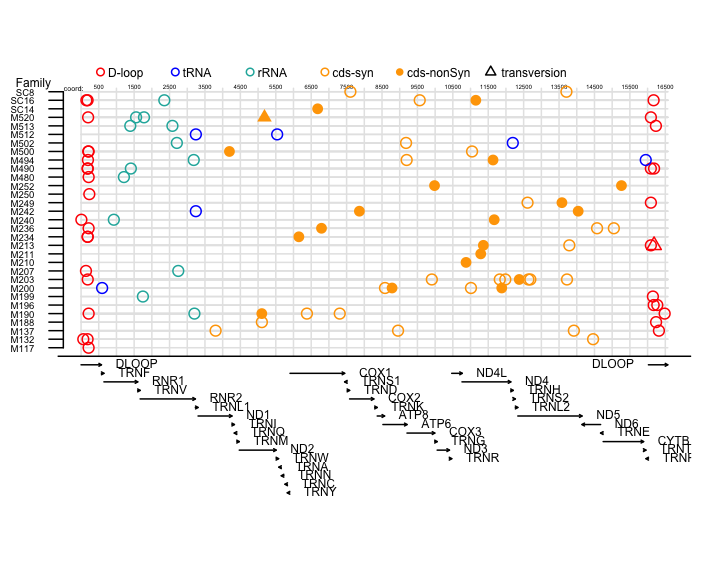

In [60]:
%%R -w 5 -h 4 -u in -r 144

# Plot area
par(mar=c(2,2,2,1))
par(oma=c(0,0,0,0))
par(las=2)
plot(data$position,data$id*5+5,xlim=c(1,16569), ylim=c(-80,170),frame="False",ylab="",axes=F, xlab="",type="n")

# Grid
for (i in data$id) {segments(1,i*5+5,16569,i*5+5,col="grey90")}
for (i in c(1,seq(500,16500,500))) {segments(i,5,i,162,col="grey90")}
for (i in seq(500,16500,1000)) {text(i,163,lab=i,col="black",cex=0.25)}
mtext("Family",3,-1.2,las=1,adj=-0.07,cex=0.5)
mtext("coord:",3,-1.35,las=1,adj=0.01,cex=0.3)

# Actual plot
points(data$position,data$id*5+5,xlim=c(1,16569), ylim=c(-80,170),pch=data$symbol,ylab="",col=data$colors, xlab="")

# Axes
abline(h=5)
lab=unique(data[,c(1,18)])
axis(2,pos=-500,at=sort(unique(data$id*5+5)),labels=lab[order(lab$id),][,1],cex.axis=0.4)

# Legend
legend(1,180,legend=c("D-loop","tRNA","rRNA","cds-syn","cds-nonSyn","transversion"),
       fill=c(NA,NA,NA,NA,NA,NA),border=c(rep("white",4),NA,NA),pch=c(1,1,1,1,16,2),
       col=c(dloop,trna,rrna,prot,prot,"black"),cex=0.5,bty="n",pt.cex=0.7,horiz=T,
       x.intersp=c(0.7,0.7,0.7,0.7,0.7,1),text.width=1350)


# mtDNA genes

Arrows(1,0,576,0,arr.length=0.05,arr.type='simple')
text(576,0,labels='DLOOP',cex=0.5,pos=4)
Arrows(576,-5,647,-5,arr.length=0.05,arr.type='simple')
text(647,-5,labels='TRNF',cex=0.5,pos=4)
Arrows(647,-10,1601,-10,arr.length=0.05,arr.type='simple')
text(1601,-10,labels='RNR1',cex=0.5,pos=4)
Arrows(1601,-15,1670,-15,arr.length=0.05,arr.type='simple')
text(1670,-15,labels='TRNV',cex=0.5,pos=4)
Arrows(1670,-20,3229,-20,arr.length=0.05,arr.type='simple')
text(3229,-20,labels='RNR2',cex=0.5,pos=4)
Arrows(3229,-25,3304,-25,arr.length=0.05,arr.type='simple')
text(3304,-25,labels='TRNL1',cex=0.5,pos=4)
Arrows(3306,-30,4262,-30,arr.length=0.05,arr.type='simple')
text(4262,-30,labels='ND1',cex=0.5,pos=4)
Arrows(4262,-35,4331,-35,arr.length=0.05,arr.type='simple')
text(4331,-35,labels='TRNI',cex=0.5,pos=4)
Arrows(4328,-40,4400,-40,arr.length=0.05,code=1,arr.type='simple')
text(4400,-40,labels='TRNQ',cex=0.5,pos=4)
Arrows(4401,-45,4469,-45,arr.length=0.05,arr.type='simple')
text(4469,-45,labels='TRNM',cex=0.5,pos=4)
Arrows(4469,-50,5511,-50,arr.length=0.05,arr.type='simple')
text(5511,-50,labels='ND2',cex=0.5,pos=4)
Arrows(5511,-55,5579,-55,arr.length=0.05,arr.type='simple')
text(5579,-55,labels='TRNW',cex=0.5,pos=4)
Arrows(5586,-60,5655,-60,arr.length=0.05,code=1,arr.type='simple')
text(5655,-60,labels='TRNA',cex=0.5,pos=4)
Arrows(5656,-65,5729,-65,arr.length=0.05,code=1,arr.type='simple')
text(5729,-65,labels='TRNN',cex=0.5,pos=4)
Arrows(5760,-70,5826,-70,arr.length=0.05,code=1,arr.type='simple')
text(5826,-70,labels='TRNC',cex=0.5,pos=4)
Arrows(5825,-75,5891,-75,arr.length=0.05,code=1,arr.type='simple')
text(5891,-75,labels='TRNY',cex=0.5,pos=4)
Arrows(5903,-5,7445,-5,arr.length=0.05,arr.type='simple')
text(7445,-5,labels='COX1',cex=0.5,pos=4)
Arrows(7445,-10,7514,-10,arr.length=0.05,code=1,arr.type='simple')
text(7514,-10,labels='TRNS1',cex=0.5,pos=4)
Arrows(7517,-15,7585,-15,arr.length=0.05,arr.type='simple')
text(7585,-15,labels='TRND',cex=0.5,pos=4)
Arrows(7585,-20,8269,-20,arr.length=0.05,arr.type='simple')
text(8269,-20,labels='COX2',cex=0.5,pos=4)
Arrows(8294,-25,8364,-25,arr.length=0.05,arr.type='simple')
text(8364,-25,labels='TRNK',cex=0.5,pos=4)
Arrows(8365,-30,8572,-30,arr.length=0.05,arr.type='simple')
text(8572,-30,labels='ATP8',cex=0.5,pos=4)
Arrows(8526,-35,9207,-35,arr.length=0.05,arr.type='simple')
text(9207,-35,labels='ATP6',cex=0.5,pos=4)
Arrows(9206,-40,9990,-40,arr.length=0.05,arr.type='simple')
text(9990,-40,labels='COX3',cex=0.5,pos=4)
Arrows(9990,-45,10058,-45,arr.length=0.05,arr.type='simple')
text(10058,-45,labels='TRNG',cex=0.5,pos=4)
Arrows(10058,-50,10404,-50,arr.length=0.05,arr.type='simple')
text(10404,-50,labels='ND3',cex=0.5,pos=4)
Arrows(10404,-55,10469,-55,arr.length=0.05,arr.type='simple')
text(10469,-55,labels='TRNR',cex=0.5,pos=4)
Arrows(10469,-5,10766,-5,arr.length=0.05,arr.type='simple')
text(10766,-5,labels='ND4L',cex=0.5,pos=4)
Arrows(10759,-10,12137,-10,arr.length=0.05,arr.type='simple')
text(12137,-10,labels='ND4',cex=0.5,pos=4)
Arrows(12137,-15,12206,-15,arr.length=0.05,arr.type='simple')
text(12206,-15,labels='TRNH',cex=0.5,pos=4)
Arrows(12206,-20,12265,-20,arr.length=0.05,arr.type='simple')
text(12265,-20,labels='TRNS2',cex=0.5,pos=4)
Arrows(12265,-25,12336,-25,arr.length=0.05,arr.type='simple')
text(12336,-25,labels='TRNL2',cex=0.5,pos=4)
Arrows(12336,-30,14148,-30,arr.length=0.05,arr.type='simple')
text(14148,-30,labels='ND5',cex=0.5,pos=4)
Arrows(14148,-35,14673,-35,arr.length=0.05,code=1,arr.type='simple')
text(14673,-35,labels='ND6',cex=0.5,pos=4)
Arrows(14673,-40,14742,-40,arr.length=0.05,code=1,arr.type='simple')
text(14742,-40,labels='TRNE',cex=0.5,pos=4)
Arrows(14746,-45,15887,-45,arr.length=0.05,arr.type='simple')
text(15887,-45,labels='CYTB',cex=0.5,pos=4)
Arrows(15887,-50,15953,-50,arr.length=0.05,arr.type='simple')
text(15953,-50,labels='TRNT',cex=0.5,pos=4)
Arrows(15955,-55,16023,-55,arr.length=0.05,code=1,arr.type='simple')
text(16023,-55,labels='TRNP',cex=0.5,pos=4)
Arrows(16024,0,16569,0,arr.length=0.05,arr.type='simple')
text(16024,0,labels='DLOOP',cex=0.5,pos=2)

## Plot correlations in minor allele frequencies (Fig. 1)

In [61]:
%%R
#head(quartets,3)
quartets[as.character(quartets$cbMinor)!=as.character(quartets$ccMinor),]

        family position mcMajor mcMinor   mcMAF mbMajor mbMinor   mbMAF ccMajor
13311     M480     1211       G       A 0.02724       G       A 0.01064       G
184184    M190      215       A       G 0.08341       A       G 0.00105       A
228194    M190     5105       T       C 0.02582       T       C 0.06139       T
265016    M494     9196       G       A 0.03235       G       A 0.02953       G
571927    M236    14573       A       G 0.30283       A       G 0.28679       A
578914    M137    16320       C       T 0.26072       C       T 0.05094       C
1017473   M240    11668       C       T 0.00045       C       T 0.00030       C
1027788   M132       64       C       T 0.00193       C       T 0.00008       C
1606252   M137     8953       A       G 0.00045       A       G 0.01268       A
1660867   M137    13918       T       C 0.00128       T       C 0.01556       T
2088521    SC8     7607       G       A 0.00725       G       A 0.01066       G
2217305   M207     2746       T       C 

There are a few cases of reversal of mninor allele frequencies between two tissues of the same individual, or between a mother and her child. Consequently, it is necessary to fix the "ancestral" allele, and we arbitrarily decided to use the maternal blood as the ancestral state.

In [62]:
%%R


# mb = maternal blood
# mc = maternal cheek
# cb = child blood
# cc = child cheek

adjustMAF = function(row){
    
    mbMajor = row[["mbMajor"]]
    mbMinor = row[["mbMinor"]]
    mcMajor = row[["mcMajor"]]
    mcMinor = row[["mcMinor"]]
    ccMajor = row[["ccMajor"]]
    ccMinor = row[["ccMinor"]]
    cbMajor = row[["cbMajor"]]
    cbMinor = row[["cbMinor"]]
    
    if ((c(mbMajor,mbMinor) == c(mcMinor,mcMajor)) & (mcMinor!=".")){
        mcMAFadj = 1 - as.numeric(row[["mcMAF"]])
    }else{
        mcMAFadj = as.numeric(row[["mcMAF"]])
    }
    
    
    if ((c(mbMajor,mbMinor) == c(ccMinor,ccMajor)) & (ccMinor!=".")){
        ccMAFadj = 1 - as.numeric(row[["ccMAF"]])
    }else{
        ccMAFadj = as.numeric(row[["ccMAF"]])
    }
    
    
    if ((c(mbMajor,mbMinor) == c(cbMinor,cbMajor)) & (cbMinor!=".")){
        cbMAFadj = 1 - as.numeric(row[["cbMAF"]])
    }else{
        cbMAFadj = as.numeric(row[["cbMAF"]])
    }
    
    return(c(mcMAFadj,ccMAFadj,cbMAFadj))
} 

In [63]:
%%R

adjustedMAF = data.frame(t(apply(quartets, 1, adjustMAF)))
colnames(adjustedMAF) = c("mc","cc","cb")

head(adjustedMAF,2)

          mc      cc      cb
2030 0.02776 0.00393 0.00128
2074 0.01217 0.00208 0.00091


Due to the adjustment of MAF based on the maternal state, comparing the child tissues independently of the mother's, require an additional adjustment. 

In [64]:
%%R

ccx=c()
for (maf in adjustedMAF$cc) {if (maf>0.5) ccx=c(ccx,(1-maf)) else ccx=c(ccx,maf)}
cbx=c()
for (maf in adjustedMAF$cb) {if (maf>0.5) cbx=c(cbx,(1-maf)) else cbx=c(cbx,maf)}


In [65]:
%%R

xyplot = function(x,y,sub,xtissue,ytissue,case){
    
    xLab = paste("het. allele frequency (",xtissue,")",sep="")
    yLab = paste("het. allele frequency (",ytissue,")",sep="")
    
    plot(x,y,pch=20,col="#00000078",axes=F,xlab=xLab,
         ylab=yLab,cex.lab=0.85,cex=2,xlim=c(0,1),ylim=c(0,1))

    abline(lm(x~y), col="darkgrey",lwd=1)
    mylabel = bquote(italic(R)^2 == .(round(summary(lm(x~y))$r.squared,2)))

    text(-0.05,0.7, pos=4,labels=mylabel,font=2,cex=1)
    text(-0.05,0.9,labels=case,cex=1,pos=4)
    mtext(sub,3,0.5,at=0,cex=1,font=1)
    axis(1,at=c(0,0.5,1))
    axis(2,at=c(0,0.5,1))
}

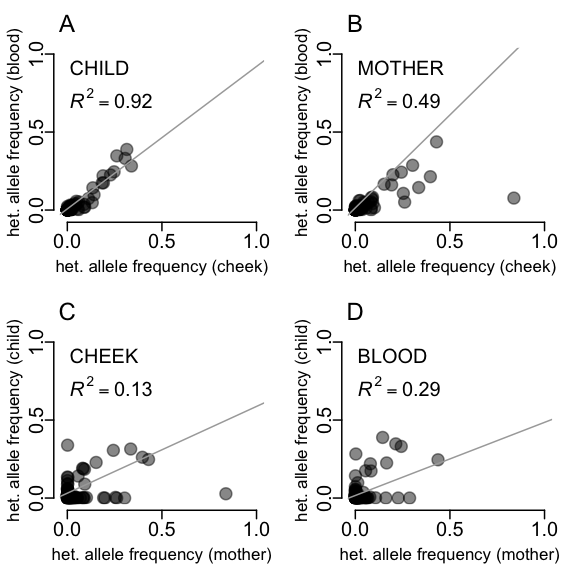

In [66]:
%%R -w 4 -h 4 -u in -r 144

par(mfrow=c(2,2))
par(oma=c(0,0,0,0))
par(mar=c(3,2.5,2,1))

par(mgp=c(1.5,0.25,0.25))
par(tck=-0.05)
    
xyplot(ccx,cbx,"A","cheek","blood","CHILD")
xyplot(adjustedMAF$mc,quartets$mbMAF,"B","cheek","blood","MOTHER")
xyplot(adjustedMAF$mc,ccx,"C","mother","child","CHEEK")
xyplot(quartets$mbMAF,cbx,"D","mother","child","BLOOD")

## Plot the bottleneck size (Fig. S15)

In [67]:
%%R

# We calculated the bottleneck size by comparing 
# the allele frequency of the minor allele in the mother and her child

bottleneckData = data.frame(
    mc=adjustedMAF$mc,
    mb=quartets[["mbMAF"]],
    cc=adjustedMAF$cc,
    cb=adjustedMAF$cb)


# We used the average of the two tissues in an individual

bottleneckData[["meanM"]] = apply(bottleneckData[,1:2], 1,mean)
bottleneckData[["meanC"]] = apply(bottleneckData[,3:4], 1,mean)


# And modeled the bottleneck as in Millar et al, 2008

bottleneckData$bn1 = (bottleneckData$meanM*(1-bottleneckData$meanM))/(bottleneckData$meanC-bottleneckData$meanM)**2
bottleneckData$bn1.cheek =(bottleneckData$mc*(1-bottleneckData$mc))/(bottleneckData$mc-bottleneckData$cc)**2
bottleneckData$bn1.blood =(bottleneckData$mb*(1-bottleneckData$mb))/(bottleneckData$mb-bottleneckData$cb)**2

# Select cases where there is evidence of the minor allele in the maternal linage (i.e. the minor allele is present in
# both tissues of the mother, at least 1% in one of the tissues, and 0.2% in the other tissue)



bn1.m = bottleneckData[(bottleneckData$mc>=0.01|bottleneckData$mb>=0.01) & 
                       (bottleneckData$mc>=0.002 & bottleneckData$mb>=0.002),][["bn1"]]

bn1.cheek = bottleneckData[bottleneckData$mc>=0.01,][["bn1.cheek"]]
bn1.blood = bottleneckData[bottleneckData$mb>=0.01,][["bn1.blood"]]

In [68]:
%%R
length(bn1.m)

[1] 51


In [69]:
%%R

# Accounting for mitotic segregation

mitotic = function(row){
    mc = row[1]
    mb = row[2]
    cc = row[3]
    cb = row[4]
    variance = ((mc-cc)^2+(mc-cb)^2+(mb-cc)^2+(mb-cc)^2-2*(mc-mb)^2-2*(cc-cb)^2)/4
    return(variance)
}

bottleneckData[["mitotvar"]] = apply(bottleneckData,1,mitotic)
bottleneckData$bn2 = (bottleneckData$meanM*(1-bottleneckData$meanM))/(bottleneckData$mitotvar)
bn2.m = bottleneckData[(bottleneckData$mc>=0.01|bottleneckData$mb>=0.01) & 
                       (bottleneckData$mc>=0.002 & bottleneckData$mb>=0.002),][["bn2"]]

In [70]:
%%R

# We removed negative or indetermined estimates of the bottleneck

bn2.m = bn2.m[bn2.m>0]

In [71]:
%%R
length(bn2.m)

[1] 48


In [72]:
%%R
bn1.m

 [1]   79.547717  189.808355   63.329506   52.377443   30.433298    1.089532
 [7]    1.391305   74.492974    1.281418 3261.362658  115.964952   21.084750
[13]    7.025862   63.732236   22.491869   31.544520   84.009669    4.666639
[19]   34.149423    5.022143   15.733035   24.621966    4.691690  271.547203
[25]  146.991653  423.537814  436.551049   20.093841    4.732199   11.793367
[31]    9.382348   17.184411  410.962516   20.899100    2.393233   32.361312
[37]    5.435722   75.299901   29.041366    4.713742  127.891910  114.086293
[43]   58.257179  112.420135  100.576177    3.714381  432.112272   23.985441
[49]  228.100474   81.035631   63.612879


In [73]:
%%R


# Get the actual stats before transforming the data
data_tmp=list(bn1.m,bn2.m)
medians=c()
first=c()
third=c()

for (i in 1:2){
    medians=c(medians,median(unlist(data_tmp[i])))
    first=c(first,summary(unlist(data_tmp[i]))[2])
    third=c(third,summary(unlist(data_tmp[i]))[5])
}

bn1.m = log10(bn1.m)
bn2.m = log10(bn2.m)

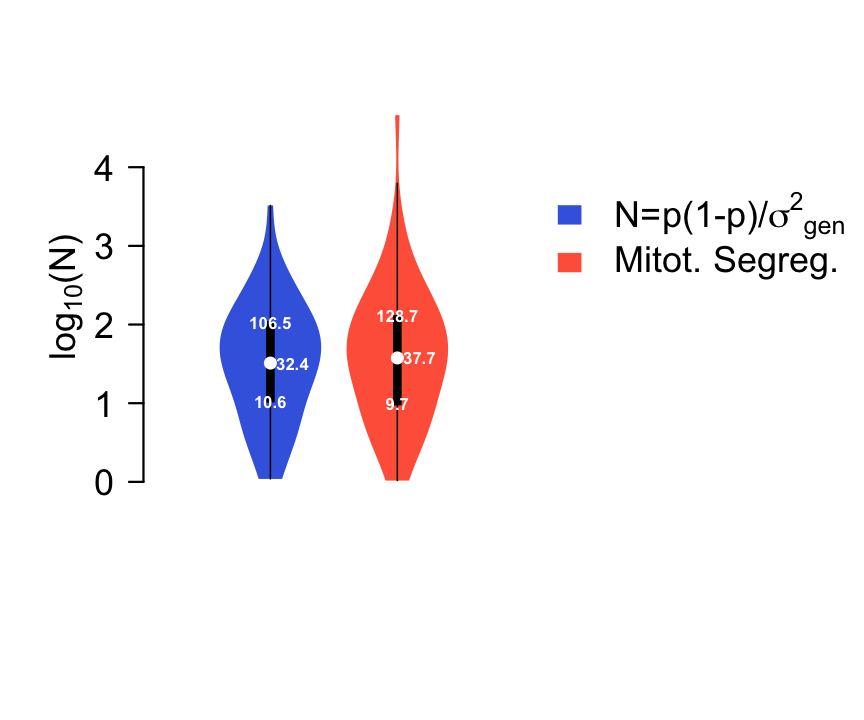

In [74]:
%%R -w 6 -h 5 -u in -r 144

par(oma=c(0,0,4,0))
par(bty="n")
par(xpd=TRUE)
par(lwd=1.5)
par(pch=20)


# blank boxplot
boxplot(bn1.m,xlim=c(0,5),ylim=c(-1,3),at=1,frame=F,axes=F, 
        ylab="",medcol="white",whiskcol="white",boxcol="white",staplecol="white")

# actual drawings
vioplot(bn1.m,ylim=c(-1,3),at=1,col="royalblue",add=T,border=NA)
vioplot(bn2.m,ylim=c(-1,3),at=2,col="tomato",add=T,border=NA,outline=F)

# y-axis
axis(2,at=seq(0,4,1),lab=seq(0,4,1),pos=0,las=2,lwd=1.5,cex.axis=1.5)

# labs 
labx = expression(paste("N=","p(1-p)/",sigma**2,""[gen]))
laby = expression(paste("log"[10],"(N)"))
mtext(laby,2,1,cex=1.5,adj=1)
legend(3,4,legend=c(labx,"Mitot. Segreg."),fill=c("royalblue","tomato"),bty="n",border="white",cex=1.5)


# Add boxplot stats to vioplot
data_tmp=list(bn1.m, bn2.m)

for (i in c(1,2)) {
    y=round(median(unlist(data_tmp[i])),2)
    text(i+0.175,y,lab=round(medians[i],1),col="white",cex=0.7,font=2)
    y=round(summary(unlist(data_tmp[i]))[2],2)
    text(i,y,lab=round(first[i],1),col="white",cex=0.7,font=2)
    y=round(summary(unlist(data_tmp[i]))[5],2)
    text(i,y,lab=round(third[i],1),col="white",cex=0.7,font=2)
}


## Plot age correlations (Fig. 2)

In [75]:
%%R

countHq = function(row){
    cheek = row[1]
    blood = row[2]
    if(cheek>=0.01|blood>=0.01){
        return(1)
    }else{
        return(0)
    }
}

In [76]:
%%R

# count the number of heteroplasmic sites with MAF ≥ 1% (in either tissue) per individual
data = quartets

data$Nmother = apply(quartets[,c(5,8)],1,FUN=countHq)
data$Nchild = apply(quartets[,c(11,14)],1,FUN=countHq)
nsites = aggregate(cbind(Nmother,Nchild) ~ family, data=data,FUN=sum)

In [77]:
%%R
head(nsites)

  family Nmother Nchild
1   M117       0      1
2   M132       2      1
3   M137       3      1
4   M188       1      2
5   M190       3      3
6   M196       1      1


In [78]:
%%R -i sampAges
colnames(sampAges) = c("mother","motherAgeCollection","child","childAgeCollection")

In [79]:
%%R

# age in days
head(sampAges)

  mother motherAgeCollection  child childAgeCollection
0   M132               16658 M132C1               7460
1   M137               14294 M137C2               6202
2   M186               15938 M186C2               3504
3   M188               17714 M188C2               3451
4   M190               18761 M190C2               5866
5   M195               11826 M195C1               2752


In [80]:
%%R
ageEffect = merge(nsites,sampAges,by.x="family",by.y="mother", all.y=TRUE)

# for samples without heteroplasmic sites, merging produces NAs, so we transformed them to zeros.
ageEffect[is.na(ageEffect)] = 0

In [81]:
%%R

# the age of the mother at the time of conception of the child is assumed to be
# the current age of the mother, less the current age of the child, less nine months (in days 9x30)
ageEffect[["motherAgeFertilization"]] = ageEffect[["motherAgeCollection"]] - (ageEffect[["childAgeCollection"]] + (9*30)) 

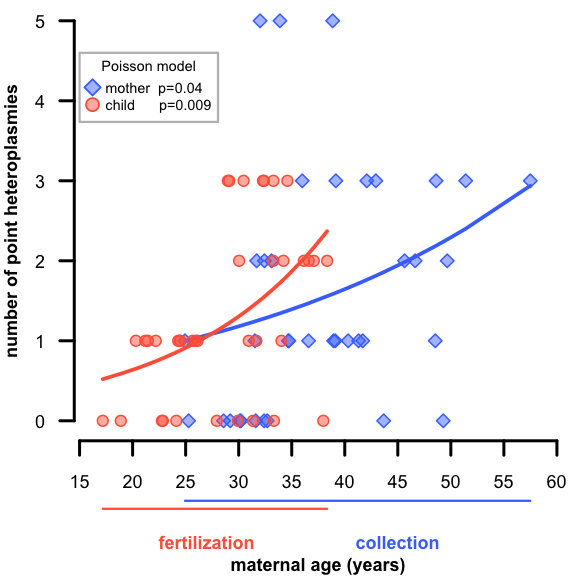

In [82]:
%%R -w 4 -h 4 -u in -r 144


# colors
black = "black"
m_col = "royalblue1"
c_col = "tomato1"

# transparent colors
mother = rgb(matrix(col2rgb(m_col),1,3),alpha=120,maxColorValue=255)
child  = rgb(matrix(col2rgb(c_col),1,3),alpha=120,maxColorValue=255)
borders = c(m_col,c_col)

# plot margins
par(oma=c(0,0,0,0))
par(mar=c(0.5,2.1,0,0))

# Mother data only
d = ageEffect[,c("Nmother","motherAgeCollection")]
plot(1:10,1:10,xlim=c(15,60),ylim=c(-1.5,5),type="n",frame=F,axes=F,xlab="",ylab="",main="")

points(d[["motherAgeCollection"]]/365,d[["Nmother"]],pch=23,col=borders[1],lwd=1,cex=1,bg=mother)
r3=glm(Nmother~motherAgeCollection,data=d,family="poisson")     
p3=round(summary(r3)$coefficients[2,4],3)
fit3=data.frame(age=r3$data$motherAgeCollection/365,f=r3$fitted.values)
fit3=fit3[order(fit3$age),]
lines(fit3$age,fit3$f,col=m_col,lwd=2.5)
x1=min(fit3$age)
x2=max(fit3$age)
pmother=round(summary(r3)$coefficients[2,4],2)

# Child data only
par(new=T)
c = ageEffect[,c("Nchild","motherAgeFertilization")]
points(c[["motherAgeFertilization"]]/365,c[["Nchild"]],pch=21,col=borders[2],bg=child,lwd=1,cex=1)
r3=glm(Nchild~motherAgeFertilization,data=c,family="poisson")
fit3=data.frame(con=r3$data$motherAgeFertilization/365,f=r3$fitted.values)
fit3=fit3[order(fit3$con),]
lines(fit3$con,fit3$f,col=c_col,lwd=2.5)
pchild=round(summary(r3)$coefficients[2,4],3)

# labs
axis(side=1,at=seq(15,60,by=5),lab=NA,lwd=2,pos=-0.25,cex.axis=0.75)
axis(side=2,at=0:5,lwd=2,pos=14.5,las=2,cex.axis=0.75)
mtext("number of point heteroplasmies",2,1.3,at=2.5,cex=0.75,font=2)
mtext("maternal age (years)",1,-0.5,cex=0.75,font=2)
for (i in seq(15,60,by=5)){text(i,-0.75,lab=i,cex=0.75)}

M=paste(paste("mother","p=",sep="  "),pmother,sep="")
C=paste(paste("child","p=",sep="      "),pchild,sep="")
legend(15,4.6,legend=c(M,C),col=borders,
       pt.bg=c(mother,child),pch=c(23,21),pt.cex=1.2,pt.lwd=1.2,
       cex=0.6,title="Poisson model",box.col="gray",box.lwd=1.5,bg=NA)

x3=min(fit3$con)
x4=max(fit3$con)

lines(c(x1,x2),c(-1,-1),lwd=1.5,col=m_col)
lines(c(x3,x4),c(-1.1,-1.1),lwd=1.5,col=c_col)
mtext("fertilization",1,-1.25,at=27,cex=0.75,col=c_col,font=2)
mtext("collection",1,-1.25,at=45,cex=0.75,col=m_col,font=2)



